# Tuning rasters for single neurons

By Charles Xu @ DJA Lab, Caltech

## Set up environment

### Import packages

In [112]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import scipy.io as sio

import sys
if '/Users/alveus/Documents/WorkingDirectory/Packages/Python' not in sys.path:
    sys.path.insert(0, '/Users/alveus/Documents/WorkingDirectory/Packages/Python')
import colormaps as cmaps # custom colormaps (see: https://gist.github.com/justiceamoh/0aca7df49c35fc0a38d2)

from scipy.stats import ttest_ind
import statsmodels.api as sm

from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA

### Helper functions

In [125]:
# Define function to perform k-means with silhouette analysis
def plot_kmeans_silhouette(range_n_clusters, data):
    """
    range_n_clusters: ndarray of size (n_clusters,)
        An array of the number of clusters to try
    data: ndarray of size (n_samples, n_features)
        Data to perform k-means clustering and silhouette analysis on
    """
    n_samples = data.shape[0]
    num_clusters = len(range_n_clusters)
    silhouette_scores = []
    fig, axs = plt.subplots(nrows=num_clusters, ncols=2, figsize=(10, 4*num_clusters), constrained_layout=True)
    for i in range(num_clusters):
        n_clusters = range_n_clusters[i]
        axs[i, 0].set_xlim([-0.1, 1])
        axs[i, 0].set_ylim([0, n_samples + (n_clusters + 1) * 10])

        # Fit the KMeans model and calculate silhouette scores
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)
        cluster_labels = kmeans.labels_
        silhouette_score_value = silhouette_score(data, cluster_labels)
        print("For n_clusters =", n_clusters, "the average silhouette_score is :", silhouette_score_value)
        silhouette_scores.append(silhouette_score_value)
        silhouetee_samples = silhouette_samples(data, cluster_labels)

        y_lower = 10
        for n in range(n_clusters):
            nth_cluster_silhouette_values = silhouetee_samples[cluster_labels == n] # Aggregate the silhouette scores for samples belonging to cluster n
            nth_cluster_silhouette_values.sort() # Sort the silhouette scores

            nth_cluster_size = nth_cluster_silhouette_values.shape[0] # Get the size of cluster n
            y_upper = y_lower + nth_cluster_size # Set the position of the silhouette plot for cluster n
            color = cm.nipy_spectral(float(n) / n_clusters)
            axs[i, 0].fill_betweenx(np.arange(y_lower, y_upper), 0, nth_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
            axs[i, 0].text(-0.05, y_lower + 0.5 * nth_cluster_size, str(n)) # Label the silhouette plots with their cluster numbers at the middle

            y_lower = y_upper + 10

        axs[i, 0].set_title("Silhouette plot for the various clusters (n_clusters = %d)" % n_clusters)
        axs[i, 0].set_xlabel("Silhouette coefficient values")
        axs[i, 0].set_ylabel("Cluster label")

        axs[i, 0].axvline(x=silhouette_score_value, color="red", linestyle="--")
        axs[i, 0].set_yticks([])  # Clear the yaxis labels / ticks
        axs[i, 0].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # Plot the cluster
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

        if data.shape[1] == 2:
            axs[i, 1].scatter(data[:, 0], data[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")
            cluster_centers = kmeans.cluster_centers_
            axs[i, 1].scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")

            for j, c in enumerate(cluster_centers):
                axs[i, 1].scatter(c[0], c[1], marker="$%d$" % j, alpha=1, s=50, edgecolor="k")

            axs[i, 1].set_title("Visualization of the clustered data (n_clusters = %d)" % n_clusters)
            axs[i, 1].set_xlabel("1st feature in feature space")
            axs[i, 1].set_ylabel("2nd feature in feature space")

        else:
            pca = PCA(n_components=2).fit(data)
            data_pca = pca.transform(data)
            axs[i, 1].scatter(data_pca[:, 0], data_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")
            cluster_centers = pca.transform(kmeans.cluster_centers_)
            axs[i, 1].scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")

            for j, c in enumerate(cluster_centers):
                axs[i, 1].scatter(c[0], c[1], marker="$%d$" % j, alpha=1, s=50, edgecolor="k")

            axs[i, 1].set_title("The visualization of the clustered data.")
            axs[i, 1].set_xlabel("PC1 in PCA mapping of feature space")
            axs[i, 1].set_ylabel("PC2 in PCA mapping of feature space")

        plt.suptitle(
            "k-means clustering with Sillhouette analysis",
            fontsize=14,
            fontweight="bold",
        )

    print("The number of clusters that maximizes silhouette score is: ", range_n_clusters[np.argmax(silhouette_scores)])
    return fig, axs, range_n_clusters[np.argmax(silhouette_scores)]

# Define function to cluster neurons
def fit_kmeans(n_clusters, data, neuron_ids=None):
    """
    n_clusters: int
        Number of clusters to group neurons into
    data: ndarray of size (n_samples, n_features)
        Data to cluster
    neuron_ids: nddarray of size (n_neurons, )
        Neuron IDs
    """
    # Fit k-means clustering with n_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)
    cluster_labels = kmeans.labels_

    # Group neurons by cluster
    data_reordered = np.zeros_like(data)
    neuron_ids_reordered = np.zeros_like(cluster_labels)
    n_ith_cluster_lower = 0
    n_ith_cluster_upper = 0
    for i in range(n_clusters):
        n_ith_cluster_upper = n_ith_cluster_lower + sum(cluster_labels == i)
        data_reordered[n_ith_cluster_lower:n_ith_cluster_upper, :] = data[cluster_labels == i, :]
        if neuron_ids is None:
            neuron_ids_reordered[n_ith_cluster_lower:n_ith_cluster_upper] = np.where(cluster_labels == i)[0] + 1
        else:
            neuron_ids_reordered[n_ith_cluster_lower:n_ith_cluster_upper] = neuron_ids[np.where(cluster_labels == i)] + 1
        n_ith_cluster_lower = n_ith_cluster_upper

    return cluster_labels, data_reordered, neuron_ids_reordered

# Define function to compare between two conditions for a given cluster of neurons for a given group of input labels
def compare_fasted_fed(mean_activity_fasted, mean_activity_fed, cluster_labels, cluster_to_plot, input_labels, input_label_to_plot):
    neuron_idx_to_plot = cluster_labels==cluster_to_plot
    input_idx_to_plot = np.array(input_labels)==input_label_to_plot
    data_fasted = mean_activity_fasted[input_idx_to_plot, neuron_idx_to_plot]
    data_fed = mean_activity_fed[input_idx_to_plot, neuron_idx_to_plot]

    # Perform t-test
    t_stat, p_val = ttest_ind(data_fasted, data_fed)

    # Determine significance
    if p_val < 0.001:
        sig = '***'
    elif p_val < 0.01:
        sig = '**'
    elif p_val < 0.05:
        sig = '*'
    else:
        sig = 'n.s.'

    # Create figure with desired width
    fig = plt.figure(figsize=(4, 5))

    # Create box plot with colored boxes and wider width
    medianprops = dict(linestyle='-', linewidth=1, color='black')
    # meanlineprops = dict(linestyle='-', linewidth=2.5, color='black')
    bp = plt.boxplot([data_fasted, data_fed], labels=['fased', 'fed'], patch_artist=True, widths=0.4, medianprops=medianprops)
    colors = ['tab:red', 'tab:green']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    # Draw line bridging the boxes
    ax = plt.gca()
    y_max = max(max(data_fasted), max(data_fed))
    ax.plot([1, 2], [y_max + 0.5, y_max + 0.5], color='black')
    ax.text(1.5, y_max + 0.7, sig + f' p-value: {p_val:.3f}', fontsize=12, horizontalalignment='center')
    ax.tick_params(axis='x', labelsize=14)  # Set x-tick label font size

    # Increase y limits
    # plt.ylim(0, y_max + 2)

    # Hide top and right edges
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.suptitle(f'{input_label_to_plot}, cluster {cluster_to_plot+1}', fontsize=16)
    plt.show()

    return fig, ax, t_stat, p_val

# Define function to plot neural activity traces with input labels
def plot_trace(y, neuron_id):
    """
    y: ndarray of size (n_samples, n_neurons)
        Neural activity
    neuron_id: int
        ID of the neuron to plot
    """
    neuron_idx = neuron_id - 1
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.plot(y[:,neuron_idx], color='k', label='neuron %d' % neuron_id)
    ax.set_xticks(np.arange(0, y.shape[0], 2000))
    ax.set_xticklabels(np.arange(0, y.shape[0], 2000) // 10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([0, y.shape[0]])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Neural activity')
    ax.set_title(f'Neural activity (z-score) for neuron {neuron_id}')

    return fig, ax

# Define function to compare between two clusters of neurons
def compare_cluster(mean_activity, cluster_labels, clusters_to_plot, boxcolors):
    fig = plt.figure(figsize=(4, 5))
    ax = plt.gca()

    handles_display = []
    for cluster_to_plot, boxcolor in zip(clusters_to_plot, boxcolors):
        clusterid = cluster_to_plot-1
        condition1 = np.ravel(mean_activity[0, cluster_labels==clusterid])
        condition2 = np.ravel(mean_activity[3:10, cluster_labels==clusterid])
        condition3 = np.ravel(mean_activity[10:14, cluster_labels==clusterid])

        # Assuming condition1, condition2, condition3 are your data
        data = [condition1, condition2, condition3]

        # Calculate means and standard deviations
        means = [np.mean(condition) for condition in data]
        std_devs = [np.std(condition) for condition in data]

        # Create boxplots
        bp = plt.boxplot(data, notch=True, patch_artist=True, widths=0.4)

        for box in bp['boxes']:
                box.set_facecolor(boxcolor)
                box.set_alpha(0.5)  # Adjust alpha value as needed

        # Show means as lines
        for i, line in enumerate(bp['medians']):
            line.set_color('k')
            line.set_linewidth(1.5)
            line.set_ydata([means[i], means[i]])

        # Connect means with a line
        ax = plt.gca()
        ax.plot(range(1, len(means) + 1), means, color=boxcolor)

    # Set xticklabels
    ax.set_xticks(np.arange(3)+1)
    ax.set_xticklabels(['baseline', 'male interaction', 'food interaction'], rotation=45)

    # Statistical comparison
    t_stat_12, p_val_12 = ttest_ind(condition1, condition2)
    t_stat_23, p_val_23 = ttest_ind(condition2, condition3)
    t_stat_13, p_val_13 = ttest_ind(condition1, condition3)

    print(f'Condition 1 vs Condition 2: t = {t_stat_12}, p = {p_val_12}')
    print(f'Condition 2 vs Condition 3: t = {t_stat_23}, p = {p_val_23}')
    print(f'Condition 1 vs Condition 3: t = {t_stat_13}, p = {t_stat_13}')

    plt.show()

### User inputs

Preprocessing is done with MATLAB using preprocessHangryMice.m. The script performs these actions:
1. Manually define behavioral label alignment and grouping.
2. Fill in behavioral data for missing labels with zeros.
3. Combine/merge stimuli labels and data.
4. Smooth neural data.
5. Save preprocessed data to .mat file.

The preprocessed data consists of the following necessary variables:
- neuralDataPreprocessed: array of size (n_neurons, n_samples). Smoothed neural data
- behaviorDataPreprocessed: array of size (n_behaviors, n_samples). Behavior data
- behaviorLabelsPreprocessed: cell array of size (n_behaviors, ). Behavior labels
- stimuliDataPreprocessed: array of size (n_stimuli, n_samples). Stimuli data
- stimuliLabelsPreprocessed: cell array of size (n_stimuli, ). Stimuli labels
- (optional) neuralData: array of size (n_neurons, n_samples). Raw neural data
Note: If compare across both conditions, make sure the labels from the two datasets match. Fill in the missing data with all zeros

In [114]:
data_path = r'/Users/alveus/Documents/WorkingDirectory/Data/DJA/Jineun/PythonData/EG1-4/priority_malemale' # Path to data on my Mac
data_name_fasted = r'EG1-4_fasted_preprocessed.mat'
data_name_fed = r'EG1-4_fed_preprocessed.mat'
exp_condition = 'fasted' # 'fasted', 'fed', or 'both'

### Load data

In [115]:
if exp_condition == 'fasted':
    data_fullfile = data_path + '/' + data_name_fasted
    mat = sio.loadmat(data_fullfile)
    input_raw = mat['behaviorDataPreprocessed'] # Behavior data
    output_raw = np.array(mat['neuralDataPreprocessed']) # Neural data
    labels_raw = mat['behaviorLabelsPreprocessed'] # Behavior labels
    labels = []
    for i in range(len(labels_raw)):
        labels.append(labels_raw[i][0][0])
    stimuli = mat['stimuliDataPreprocessed'] # Stimuli
    stimuli_labels_raw = mat['stimuliLabelsPreprocessed'] # Stimuli labels
    stimuli_labels = []
    for i in range(len(stimuli_labels_raw)):
        stimuli_labels.append(stimuli_labels_raw[i][0][0])
elif exp_condition == 'fed':
    data_fullfile = data_path + '/' + data_name_fed
    mat = sio.loadmat(data_fullfile)
    input_raw = mat['behaviorDataPreprocessed'] # Behavior data
    output_raw = np.array(mat['neuralDataPreprocessed']) # Neural data
    labels_raw = mat['behaviorLabelsPreprocessed'] # Behavior labels
    labels = []
    for i in range(len(labels_raw)):
        labels.append(labels_raw[i][0][0])
    stimuli = mat['stimuliDataPreprocessed'] # Stimuli
    stimuli_labels_raw = mat['stimuliLabelsPreprocessed'] # Stimuli labels
    stimuli_labels = []
    for i in range(len(stimuli_labels_raw)):
        stimuli_labels.append(stimuli_labels_raw[i][0][0])
elif exp_condition == 'both':
    data_fullfile_fasted = data_path + '/' + data_name_fasted
    data_fullfile_fed = data_path + '/' + data_name_fed

    mat_fasted = sio.loadmat(data_fullfile_fasted)
    mat_fed = sio.loadmat(data_fullfile_fed)

    input_raw_fasted = mat_fasted['behaviorDataPreprocessed'] # Behavior data
    input_raw_fed = mat_fed['behaviorDataPreprocessed']

    output_raw_fasted = np.array(mat_fasted['neuralDataPreprocessed']) # Neural data
    output_raw_fed = np.array(mat_fed['neuralDataPreprocessed'])

    labels_raw_fasted = mat_fasted['behaviorLabelsPreprocessed'] # Behavior labels
    labels_fasted = [] # Behavior labels
    for i in range(len(labels_raw_fasted)):
        labels_fasted.append(labels_raw_fasted[i][0][0])

    labels_raw_fed = mat_fed['behaviorLabelsPreprocessed']
    labels_fed = [] # Behavior labels
    for i in range(len(labels_raw_fed)):
        labels_fed.append(labels_raw_fed[i][0][0])

    if all(labels_raw_fasted == labels_raw_fed):
        labels = labels_fasted
    else:
        sys.exit('Stimuli labels do not match!')

    stimuli_fasted = mat_fasted['stimuliDataPreprocessed'] # Stimuli
    stimuli_labels_fasted_raw = mat_fasted['stimuliLabelsPreprocessed'] # Stimuli labels
    stimuli_labels_fasted = []
    for i in range(len(stimuli_labels_fasted_raw)):
        stimuli_labels_fasted.append(stimuli_labels_fasted_raw[i][0][0])

    stimuli_fed = mat_fed['stimuliDataPreprocessed'] # Stimuli
    stimuli_labels_fed_raw = mat_fed['stimuliLabelsPreprocessed'] # Stimuli labels
    stimuli_labels_fed = []
    for i in range(len(stimuli_labels_fed_raw)):
        stimuli_labels_fed.append(stimuli_labels_fed_raw[i][0][0])
else:
    sys.exit('Wrong experiment condition! Specify either "fasted", "fed", or "both".')


In [116]:
if exp_condition == 'both':
    print(f'Number of input variables (fasted): {input_raw_fasted.shape[0]}')
    print(f'Length of session (fasted): {input_raw_fasted.shape[1]}')
    print(f'Number of input variables (fed): {input_raw_fed.shape[0]}')
    print(f'Length of session (fed): {input_raw_fed.shape[1]}')
    print(f'The input variables are: {labels}')
    print(f'Number of output variables (fasted): {output_raw_fasted.shape[0]}')
    print(f'Number of output variables (fed): {output_raw_fed.shape[0]}')
    print(f'Number of stimuli variables (fasted): {stimuli_fasted.shape[0]}')
    print(f'The stimuli variables (fasted) are: {stimuli_labels_fasted}')
    print(f'Number of stimuli variables (fed): {stimuli_fed.shape[0]}')
    print(f'The stimuli variables (fed) are: {stimuli_labels_fed}')
else:
    print(f'Number of input variables: {input_raw.shape[0]}')
    print(f'Length of session: {input_raw.shape[1]}')
    print(f'The input variables are: {labels}')
    print(f'Number of output variables: {output_raw.shape[0]}')
    print(f'Number of stimuli variables: {stimuli.shape[0]}')
    print(f'The stimuli variables are: {stimuli_labels}')

Number of input variables: 15
Length of session: 14759
The input variables are: ['baseline', 'danglingM', 'introduction', 'male_approach', 'sniffM', 'sniff_face', 'mountM', 'chasing', 'attack_attempt', 'attack', 'food_approach', 'food_sniff', 'eating', 'drinking', 'self_grooming']
Number of output variables: 73
Number of stimuli variables: 5
The stimuli variables are: ['baseline', 'male', 'object', 'food', 'male2']


## Process data

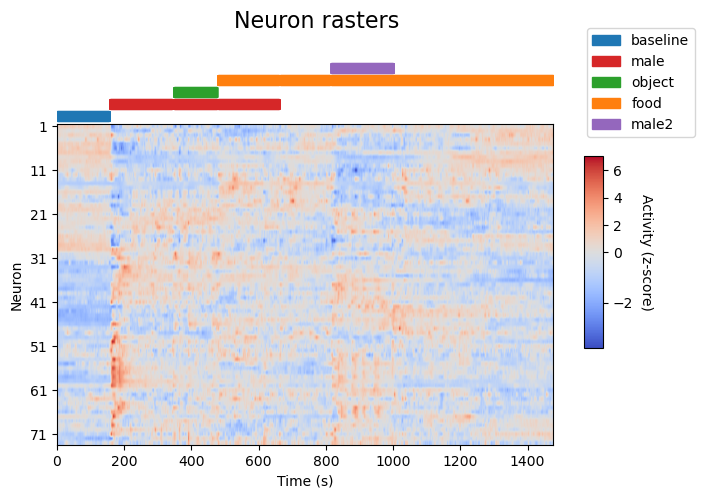

In [119]:
# Plot raw neuron rasters
if exp_condition == 'both':
    n_neurons = output_raw_fasted.shape[0]
    time_fasted = output_raw_fasted.shape[1]
    time_fed = output_raw_fed.shape[1]

    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(15, 5), gridspec_kw={'height_ratios': [1, 5]})
    fig.subplots_adjust(hspace=0, wspace=0.1)

    # Determine the color scale based on the min and max of both datasets
    vmin = min(output_raw_fasted.min(), output_raw_fed.min())
    vmax = max(output_raw_fasted.max(), output_raw_fed.max())

    # Add colored bars for the stimuli in the fasted condition
    y1 = 0
    thickness = 0.05
    y2 = y1 + thickness
    space = 0.01
    bar_colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple']
    handles_display = []
    for i in range(len(stimuli_labels_fasted)):
        first = True
        # if i == 2: continue
        for j in range(time_fasted):
            if stimuli_fasted[i, j] and first:
                axs[0, 0].fill_between([j, j+1], y1, y2, color=bar_colors[i], label=stimuli_labels_fasted[i])
                handles, _ = axs[0, 0].get_legend_handles_labels()
                handles_display.append(handles[-1])
                first = False
            elif stimuli_fasted[i, j]:
                axs[0, 0].fill_between([j, j+1], y1, y2, color=bar_colors[i])
        y1 = y2 + space
        y2 = y1 + thickness
    axs[0, 0].set_xlim([0, time_fasted])
    axs[0, 0].axis('off')
    axs[0, 0].set_title('Fasted')

    # Add colored bars for the stimuli in the fed condition
    y1 = 0
    thickness = 0.05
    y2 = y1 + thickness
    space = 0.01
    bar_colors = ['tab:blue', 'tab:red', 'tab:orange', 'tab:purple']
    for i in range(len(stimuli_labels_fed)):
        for j in range(time_fed):
            if stimuli_fed[i, j]:
                axs[0, 1].fill_between([j, j+1], y1, y2, color=bar_colors[i])
        y1 = y2 + space
        y2 = y1 + thickness
    axs[0, 1].set_xlim([0, time_fed])
    axs[0, 1].axis('off')
    axs[0, 1].set_title('Fed')
    axs[0, 1].legend(handles_display, stimuli_labels_fasted, loc='upper right', bbox_to_anchor=(1.3, 1.6))

    # Create a diverging color map normalized around 0
    divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    # Plot the neuron raster for the fasted condition
    im0 = axs[1, 0].imshow(output_raw_fasted, cmap='coolwarm', aspect='auto', norm=divnorm)
    axs[1, 0].set_xticks(np.arange(time_fasted, step=2000))
    axs[1, 0].set_xticklabels(np.arange(time_fasted, step=2000)//10)
    axs[1, 0].set_xlabel('Time (s)')
    axs[1, 0].set_yticks(np.arange(n_neurons, step=10))
    axs[1, 0].set_yticklabels(np.arange(n_neurons, step=10)+1)
    axs[1, 0].set_ylabel('Neuron')

    # Plot the neuron raster for the fed condition
    im1 = axs[1, 1].imshow(output_raw_fed, cmap='coolwarm', aspect='auto', norm=divnorm)
    axs[1, 1].set_xticks(np.arange(time_fed, step=2000))
    axs[1, 1].set_xticklabels(np.arange(time_fed, step=2000)//10)
    axs[1, 1].set_xlabel('Time (s)')
    axs[1, 1].set_yticks([])

    plt.suptitle('Neuron rasters', fontsize=16, x=0.45)

    # Add a colarbar
    cbar = fig.colorbar(im0, ax=axs, shrink=0.5, aspect=10)
    cbar.set_label('Activity (z-score)', rotation=-90, va="bottom")

    plt.show()
else:
    n_neurons = output_raw.shape[0]
    time_length = output_raw.shape[1]

    fig, axs = plt.subplots(nrows = 2, figsize=(8, 5), gridspec_kw={'height_ratios': [1, 5]})
    fig.subplots_adjust(hspace=0, wspace=0.1)

    # Determine the color scale based on the min and max of both datasets
    vmin = output_raw.min()
    vmax = output_raw.max()

    # Add colored bars for the stimuli
    y1 = 0
    thickness = 0.05
    y2 = y1 + thickness
    space = 0.01
    bar_colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple']
    handles_display = []
    for i in range(len(stimuli_labels)):
        first = True
        for j in range(time_length):
            if stimuli[i, j] and first:
                axs[0].fill_between([j, j+1], y1, y2, color=bar_colors[i], label=stimuli_labels[i])
                handles, _ = axs[0].get_legend_handles_labels()
                handles_display.append(handles[-1])
                first = False
            elif stimuli[i, j]:
                axs[0].fill_between([j, j+1], y1, y2, color=bar_colors[i])
        y1 = y2 + space
        y2 = y1 + thickness
    axs[0].set_xlim([0, time_length])
    axs[0].axis('off')
    axs[0].legend(handles_display, stimuli_labels, loc='upper right', bbox_to_anchor=(1.3, 1.6))
    
    # Create a diverging color map normalized around 0
    divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    # Plot the neuron raster
    im = axs[1].imshow(output_raw, cmap='coolwarm', aspect='auto', norm=divnorm)
    axs[1].set_xticks(np.arange(time_length, step=2000))
    axs[1].set_xticklabels(np.arange(time_length, step=2000)//10)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_yticks(np.arange(n_neurons, step=10))
    axs[1].set_yticklabels(np.arange(n_neurons, step=10)+1)
    axs[1].set_ylabel('Neuron')

    plt.suptitle('Neuron rasters', fontsize=16, x=0.45)

    # Add a colarbar
    cbar = fig.colorbar(im, ax=axs, shrink=0.5, aspect=10)
    cbar.set_label('Activity (z-score)', rotation=-90, va="bottom")

    plt.show()

#### Compute mean activity for each neuron and each behavior

In [120]:
n_labels = len(labels)
group_indices = [1, 3, 10, 14] # Indices of the first behavior in each group

In [121]:
if exp_condition == 'both':
    mean_activity_fasted = np.zeros((n_labels, n_neurons))
    mean_activity_fed = np.zeros((n_labels, n_neurons))
    for l in range(n_labels):
        mean_activity_fasted[l,:] = np.nan_to_num(np.mean(output_raw_fasted[:,np.where(input_raw_fasted[l,:] == 1)[0]], axis=1))
        mean_activity_fed[l,:] = np.nan_to_num(np.mean(output_raw_fed[:,np.where(input_raw_fed[l,:] == 1)[0]], axis=1))
else:
    n_neurons = output_raw.shape[0]
    mean_activity = np.zeros((n_labels, n_neurons))
    for l in range(n_labels):
        mean_activity[l,:] = np.nan_to_num(np.mean(output_raw[:,np.where(input_raw[l,:] == 1)[0]], axis=1))

/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Text(0.5, 0.98, 'Mean activity')

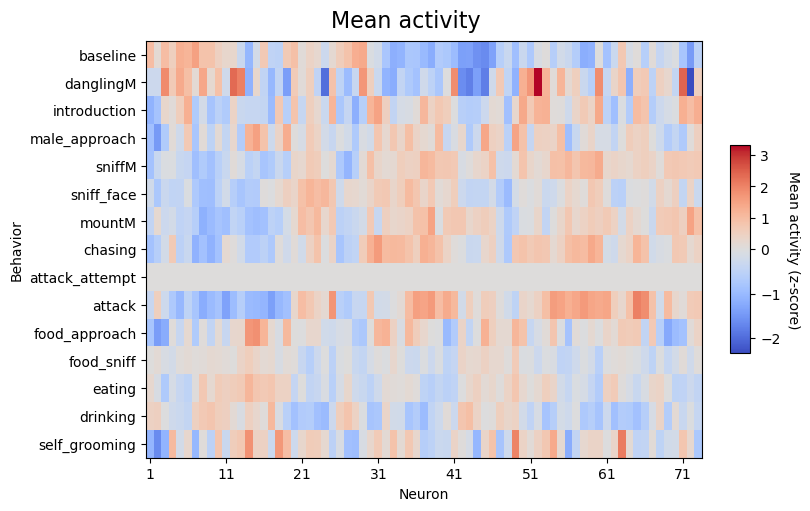

In [122]:
# Plot mean activity
if exp_condition == 'both':
    fig, axs = plt.subplots(ncols = 2, figsize=(15, 5), constrained_layout=True)

    # Determine the color scale based on the min and max of both datasets
    vmin = min(mean_activity_fasted.min(), mean_activity_fed.min())
    vmax = max(mean_activity_fasted.max(), mean_activity_fed.max())
    divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    im0 = axs[0].imshow(mean_activity_fasted, cmap='coolwarm', aspect='auto', norm=divnorm)
    axs[0].set_title('Fasted')
    axs[0].set_xticks(np.arange(n_neurons, step=10))
    axs[0].set_xticklabels(np.arange(n_neurons, step=10)+1)
    axs[0].set_xlabel('Neuron')
    axs[0].set_yticks(np.arange(n_labels))
    axs[0].set_yticklabels(labels)
    axs[0].set_ylabel('Behavior')

    im1 = axs[1].imshow(mean_activity_fed, cmap='coolwarm', aspect='auto', norm=divnorm)
    axs[1].set_title('Fed')
    axs[1].set_xticks(np.arange(n_neurons, step=10))
    axs[1].set_xticklabels(np.arange(n_neurons, step=10)+1)
    axs[1].set_xlabel('Neuron')

    # Add a colarbar
    cbar = fig.colorbar(im0, ax=axs, shrink=0.5, aspect=10)
    cbar.set_label('Mean activity (z-score)', rotation=-90, va="bottom")
else:
    fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
    vmin = mean_activity.min()
    vmax = mean_activity.max()
    divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    im = ax.imshow(mean_activity, cmap='coolwarm', aspect='auto', norm=divnorm)
    ax.set_xticks(np.arange(n_neurons, step=10))
    ax.set_xticklabels(np.arange(n_neurons, step=10)+1)
    ax.set_xlabel('Neuron')
    ax.set_yticks(np.arange(n_labels))
    ax.set_yticklabels(labels)
    ax.set_ylabel('Behavior')
    cbar = fig.colorbar(im, ax=ax, shrink=0.5, aspect=10)
    cbar.set_label('Mean activity (z-score)', rotation=-90, va="bottom")

plt.suptitle('Mean activity', fontsize=16)

## Cluster neurons

In [123]:
# Perform k-means with silhouette analysis
range_n_clusters = np.arange(2, n_labels+1) # Generate range of number of clusters to evaluate

if exp_condition == 'both':
    fig, axs, n_clusters_fasted = plot_kmeans_silhouette(range_n_clusters, mean_activity_fasted.T)
    plt.close(fig)
    fig, axs, n_clusters_fed = plot_kmeans_silhouette(range_n_clusters, mean_activity_fed.T)
    plt.close(fig)
else:
    fig, axs, n_clusters = plot_kmeans_silhouette(range_n_clusters, mean_activity.T)
    plt.close(fig)

/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/

For n_clusters = 2 the average silhouette_score is : 0.2446513348971734
For n_clusters = 3 the average silhouette_score is : 0.2061150472194578
For n_clusters = 4 the average silhouette_score is : 0.18341590597729393
For n_clusters = 5 the average silhouette_score is : 0.19230231616895543
For n_clusters = 6 the average silhouette_score is : 0.17068634056793983


/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/

For n_clusters = 7 the average silhouette_score is : 0.16870434817191526
For n_clusters = 8 the average silhouette_score is : 0.1756347062255305
For n_clusters = 9 the average silhouette_score is : 0.16564653832923099


/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 10 the average silhouette_score is : 0.17752752994239013
For n_clusters = 11 the average silhouette_score is : 0.14071993353562778
For n_clusters = 12 the average silhouette_score is : 0.16310356866490217


/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 13 the average silhouette_score is : 0.15370779736225465
For n_clusters = 14 the average silhouette_score is : 0.15134127698125038
For n_clusters = 15 the average silhouette_score is : 0.1487702939213369
The number of clusters that maximizes silhouette score is:  2


## Generate raster plots

/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 0.98, 'Tuning raster')

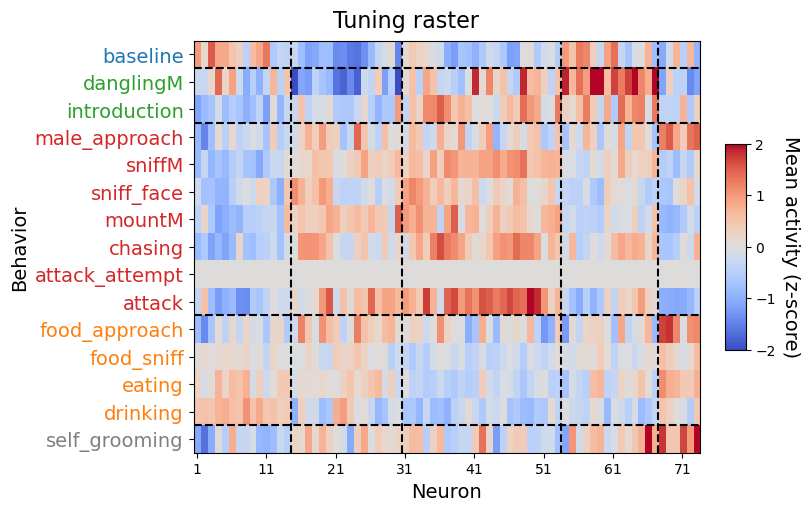

In [124]:
# Plot tuning raster
if exp_condition == 'both':
    # Fit k-means clustering
    n_clusters_fasted = 5
    n_clusters_fed = 4
    cluster_labels_fasted, data_reordered_fasted, neuron_ids_reordered_fasted = fit_kmeans(n_clusters_fasted, mean_activity_fasted.T)
    cluster_labels_fed, data_reordered_fed, neuron_ids_reordered_fed = fit_kmeans(n_clusters_fed, mean_activity_fed.T)

    # Plot tuning raster
    fig, axs = plt.subplots(ncols = 2, figsize=(15, 5), constrained_layout=True)

    # Determine the color scale based on the min and max of both datasets
    vmin = min(mean_activity_fasted.min(), mean_activity_fed.min())
    vmax = max(mean_activity_fasted.max(), mean_activity_fed.max())
    divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    # Plot the first raster
    im0 = axs[0].imshow(data_reordered_fasted.T, cmap='coolwarm', aspect='auto', vmin=-2, vmax=2)
    axs[0].set_title('Fasted')
    axs[0].set_xticks(np.arange(n_neurons, step=10))
    axs[0].set_xticklabels(np.arange(n_neurons, step=10)+1)
    axs[0].set_xlabel('Neuron')
    axs[0].set_yticks(np.arange(n_labels))
    axs[0].set_yticklabels(labels)
    axs[0].set_ylabel('Behavior')

    # Separate clusters
    for i in range(1, n_clusters_fasted):
        axs[0].axvline(x=np.sum(cluster_labels_fasted < i) - 1/2, color='black', linestyle='--')

    # Separate behaviors
    for b in group_indices:
        axs[0].axhline(y=b-1/2, color='black', linestyle='--')

    # Plot the second raster
    im1 = axs[1].imshow(data_reordered_fed.T, cmap='coolwarm', aspect='auto', vmin=-2, vmax=2)
    axs[1].set_title('Fed')
    axs[1].set_xticks(np.arange(n_neurons, step=10))
    axs[1].set_xticklabels(np.arange(n_neurons, step=10)+1)
    axs[1].set_xlabel('Neuron')
    axs[1].set_yticks([])

    # Separate clusters
    for i in range(1, n_clusters_fed):
        axs[1].axvline(x=np.sum(cluster_labels_fed < i) - 1/2, color='black', linestyle='--')

    # Separate behaviors
    for b in group_indices:
        axs[1].axhline(y=b-1/2, color='black', linestyle='--')

    # Add a colarbar
    cbar = fig.colorbar(im0, ax=axs, shrink=0.5, aspect=10)
    cbar.set_label('Mean activity (z-score)', rotation=-90, va="bottom")
else:
    # Fit k-means clustering with n_labels
    n_clusters = 5
    cluster_labels, data_reordered, neuron_ids_reordered = fit_kmeans(n_clusters, mean_activity.T)

    fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)

    # Determine the color scale based on the min and max of both datasets
    vmin = mean_activity.min()
    vmax = mean_activity.max()
    divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    # Plot the first raster
    im = ax.imshow(data_reordered.T, cmap='coolwarm', aspect='auto', vmin=-2, vmax=2)
    ax.set_xticks(np.arange(n_neurons, step=10))
    ax.set_xticklabels(np.arange(n_neurons, step=10)+1)
    ax.set_xlabel('Neuron', fontsize=14)
    ax.set_yticks(np.arange(n_labels))
    ax.set_yticklabels(labels, fontsize=14)
    ax.set_ylabel('Behavior', fontsize=14)

    ytickcolors = ['tab:blue',
                   'tab:green', 'tab:green',
                   'tab:red', 'tab:red', 'tab:red', 'tab:red', 'tab:red', 'tab:red', 'tab:red',
                   'tab:orange', 'tab:orange', 'tab:orange', 'tab:orange',
                   'tab:gray']
    # Get the yticklabels and set their color
    for i, yticklabel in enumerate(ax.get_yticklabels()):
        yticklabel.set_color(ytickcolors[i % len(ytickcolors)])

    # Separate clusters
    for i in range(1, n_clusters):
        ax.axvline(x=np.sum(cluster_labels < i) - 1/2, color='black', linestyle='--')

    # Separate behaviors
    for b in group_indices:
        ax.axhline(y=b-1/2, color='black', linestyle='--')

    # Add a colarbar
    cbar = fig.colorbar(im, ax=ax, shrink=0.5, aspect=10)
    cbar.set_label('Mean activity (z-score)', rotation=-90, va="bottom", fontsize=14)

plt.suptitle('Tuning raster', fontsize=16)

## EDA

### Box plots for individual inputs

### Comparing co-registered neurons across days

/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 0.98, 'Tuning raster (fasted to fed)')

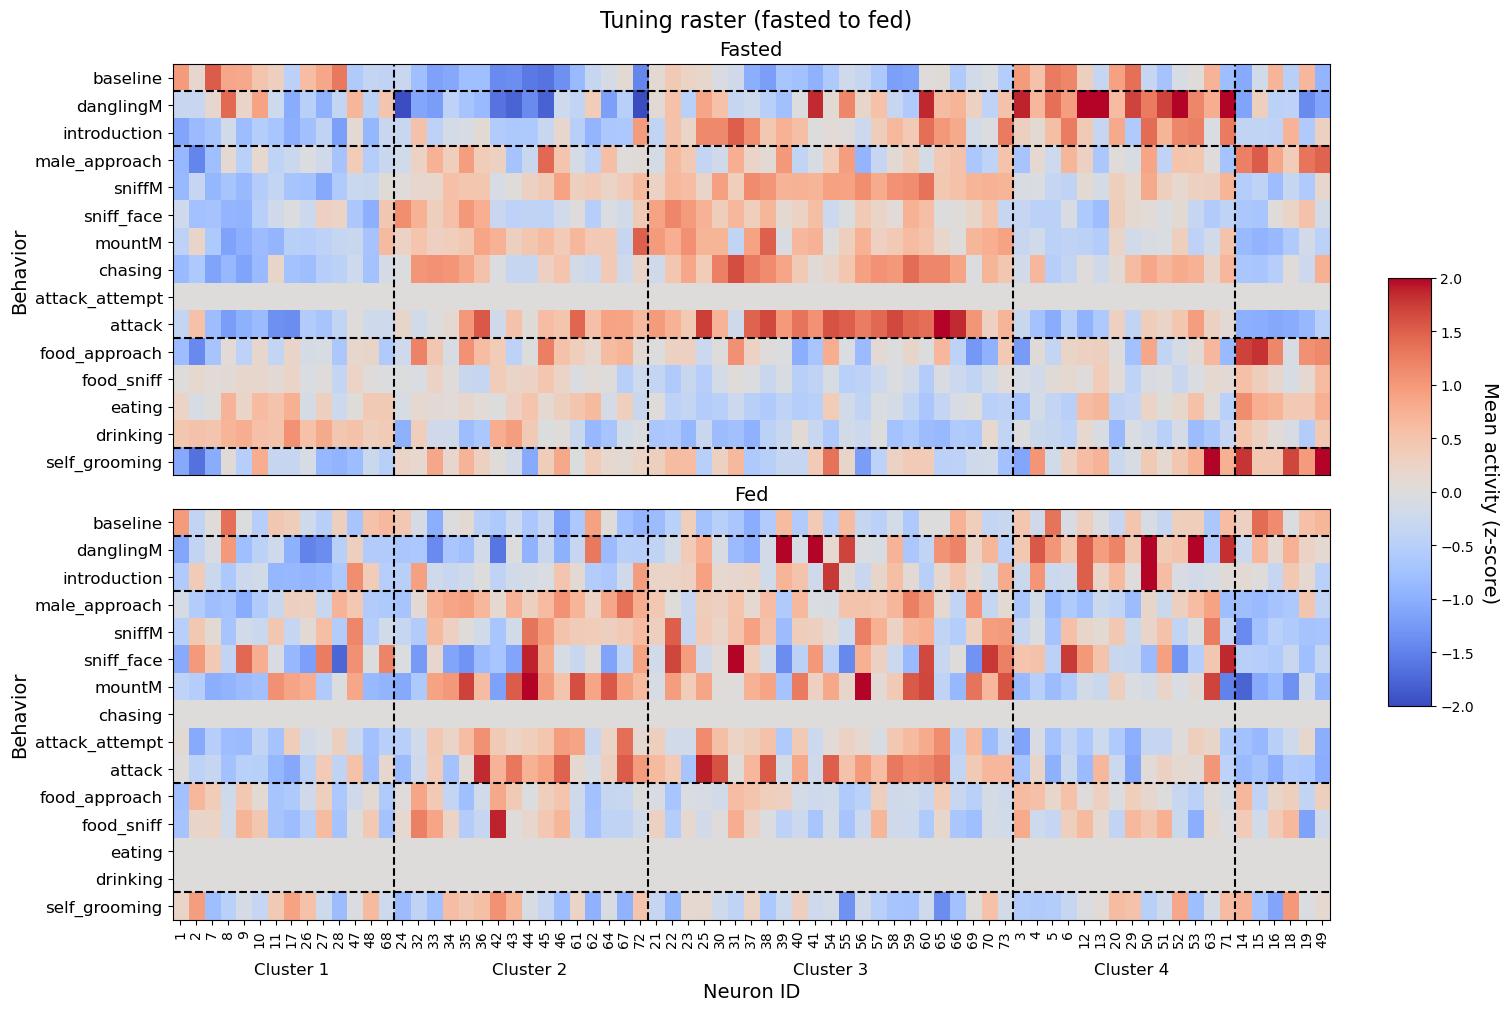

In [18]:
# Plot tuning raster (fasted to fed)
if exp_condition == 'both':
    # Fit k-means clustering with n_labels
    n_clusters_fasted = 5
    cluster_labels_fasted, data_reordered_fasted, neuron_ids_reordered_fasted = fit_kmeans(n_clusters_fasted, mean_activity_fasted.T)
    data_reordered_fed = mean_activity_fed.T[neuron_ids_reordered_fasted-1, :]

    # Plot tuning raster
    fig, axs = plt.subplots(nrows = 2, figsize=(15, 10), constrained_layout=True)

    # Determine the color scale based on the min and max of both datasets
    vmin = min(mean_activity_fasted.min(), mean_activity_fed.min())
    vmax = max(mean_activity_fasted.max(), mean_activity_fed.max())
    divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    # Plot the first raster
    im0 = axs[0].imshow(data_reordered_fasted.T, cmap='coolwarm', aspect='auto', vmin=-2, vmax=2)
    axs[0].set_title('Fasted', fontsize=14)
    axs[0].set_xticks([])
    axs[0].set_yticks(np.arange(n_labels))
    axs[0].set_yticklabels(labels, fontsize=12)
    axs[0].set_ylabel('Behavior', fontsize=14)

    # Separate clusters
    for i in range(1, n_clusters_fasted):
        axs[0].axvline(x=np.sum(cluster_labels_fasted < i) - 1/2, color='black', linestyle='--')

    # Separate behaviors
    for b in group_indices:
        axs[0].axhline(y=b-1/2, color='black', linestyle='--')

    # Plot the second raster
    im1 = axs[1].imshow(data_reordered_fed.T, cmap='coolwarm', aspect='auto', vmin=-2, vmax=2)
    axs[1].set_title('Fed', fontsize=14)
    axs[1].set_xticks(np.arange(n_neurons))
    axs[1].set_xticklabels(neuron_ids_reordered_fasted, rotation=90)
    axs[1].set_xlabel('Neuron ID', fontsize=14, labelpad=25)
    axs[1].set_yticks(np.arange(n_labels))
    axs[1].set_yticklabels(labels, fontsize=12)
    axs[1].set_ylabel('Behavior', fontsize=14)

    # Separate clusters
    for i in range(1, n_clusters_fasted):
        axs[1].axvline(x=np.sum(cluster_labels_fasted < i) - 1/2, color='black', linestyle='--')
        axs[1].text(np.sum(cluster_labels_fasted < i-1) + np.sum(cluster_labels_fasted == i-1)//2, n_labels+1.5, f'Cluster {i}', fontsize=12, ha='center')

    # Separate behaviors
    for b in group_indices:
        axs[1].axhline(y=b-1/2, color='black', linestyle='--')

    # Add a colarbar
    cbar = fig.colorbar(im0, ax=axs, shrink=0.5, aspect=10)
    cbar.set_label('Mean activity (z-score)', fontsize=14, rotation=-90, va="bottom")

fig.suptitle('Tuning raster (fasted to fed)', fontsize=16)

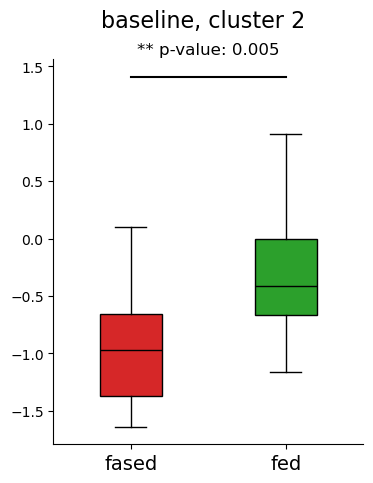

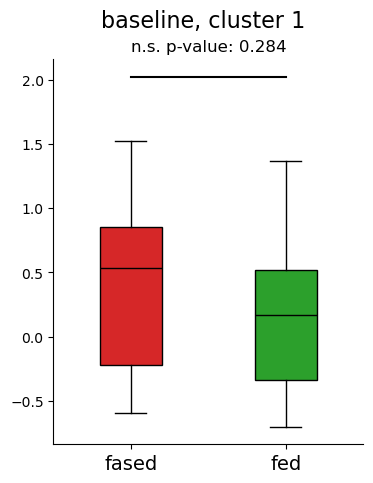

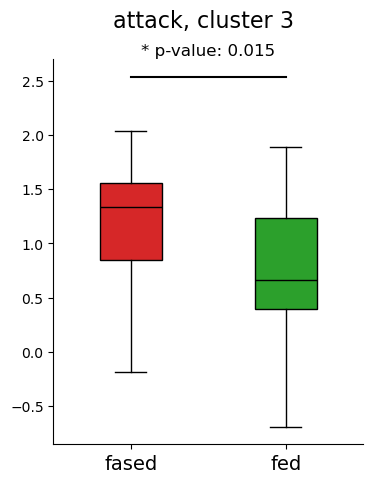

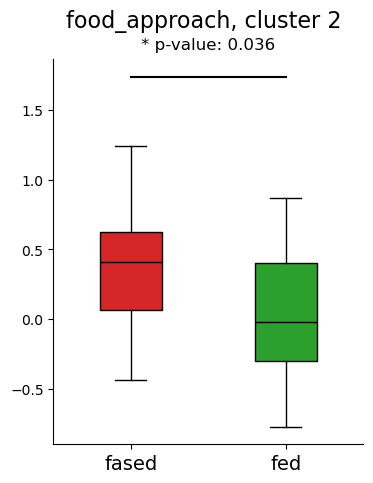

In [20]:
fig, ax, t_stat, p_val = compare_fasted_fed(mean_activity_fasted, mean_activity_fed, cluster_labels_fasted, 1, labels, 'baseline')
fig, ax, t_stat, p_val = compare_fasted_fed(mean_activity_fasted, mean_activity_fed, cluster_labels_fasted, 0, labels, 'baseline')
fig, ax, t_stat, p_val = compare_fasted_fed(mean_activity_fasted, mean_activity_fed, cluster_labels_fasted, 2, labels, 'attack')
fig, ax, t_stat, p_val = compare_fasted_fed(mean_activity_fasted, mean_activity_fed, cluster_labels_fasted, 1, labels, 'food_approach')

Condition 1 vs Condition 2: t = -9.704130984469511, p = 5.760347324247895e-17
Condition 2 vs Condition 3: t = 2.4311778192188425, p = 0.016064308078509382
Condition 1 vs Condition 3: t = -7.843377097547841, p = -7.843377097547841


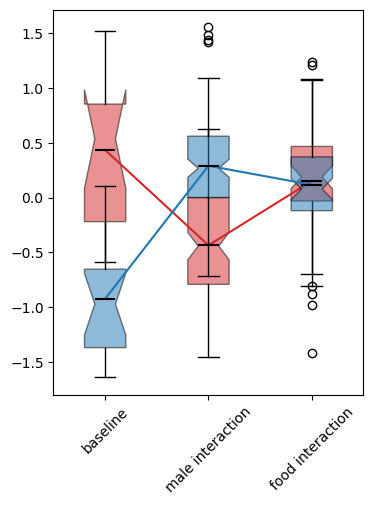

In [126]:
compare_cluster(mean_activity, cluster_labels, [1, 2], ['tab:red', 'tab:blue'])

(<Figure size 1500x400 with 1 Axes>,
 <Axes: title={'center': 'Neural activity (z-score) for neuron 1'}, xlabel='Time (s)', ylabel='Neural activity'>)

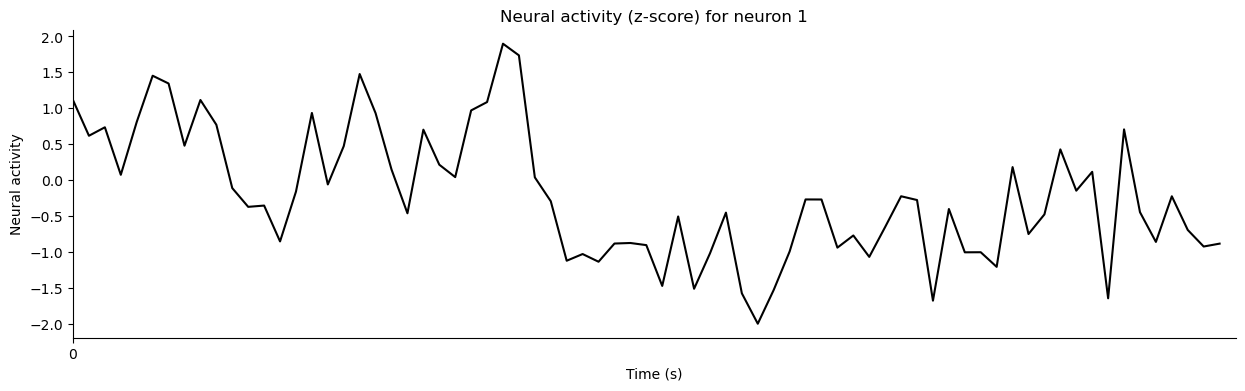

In [23]:
plot_trace(output_raw_fasted, 1)

## Notes

- Two conditions are z-scored separately
- Truncate the second entry